In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargo la base limpia que ya se había generado en la etapa de preprocesamiento
df = pd.read_csv("df_cleaned.csv")

# Defino el target del modelo 2 como el logaritmo natural del precio
# (mismo target conceptual del modelo 1, pero acá lo optimizamos para desempeño)
y_nn = np.log(df["price"])

# Tomo solo las columnas numéricas como variables de entrada
# (incluye dummies y variables binarias que creamos antes)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Quito la columna de precio de las variables explicativas para no predecirnos a nosotros mismos
feature_cols_nn = [col for col in numeric_cols if col != "price"]

X_nn = df[feature_cols_nn].copy()

# Parto los datos en entrenamiento y prueba para poder evaluar bien la red
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn,
    y_nn,
    test_size=0.2,
    random_state=100
)

# Convierto a float32 y a matrices de numpy porque así trabaja mejor TensorFlow/Keras
X_train_nn = X_train_nn.astype("float32").values
X_test_nn = X_test_nn.astype("float32").values
y_train_nn = y_train_nn.astype("float32").values
y_test_nn = y_test_nn.astype("float32").values

# Reviso tamaños para confirmar que todo quedó bien armado
print("X_train_nn:", X_train_nn.shape)
print("X_test_nn :", X_test_nn.shape)
print("y_train_nn:", y_train_nn.shape)
print("y_test_nn :", y_test_nn.shape)


X_train_nn: (16661, 98)
X_test_nn : (4166, 98)
y_train_nn: (16661,)
y_test_nn : (4166,)


In [ ]:
import setuptools.dist  # en algunas versiones de Python esto evita problemas al importar tensorflow
import tensorflow as tf

# Fijo semillas para que los resultados sean lo más reproducibles posible
np.random.seed(123)
tf.random.set_seed(123)

# Dimensión de entrada para la red (tantas neuronas como columnas en X)
input_dim = X_train_nn.shape[1]

# Capa de normalización: aprende media y desviación de las variables de entrada
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train_nn)

def build_mlp_model(
    n_hidden_layers=2,
    units_per_layer=64,
    dropout_rate=0.10,
    learning_rate=0.001
):
    """
    Se pasan como argumentos para poder probar varias configuraciones después.
    """
    model = tf.keras.Sequential()
    
    # Entrada + normalización de todas las variables explicativas
    model.add(tf.keras.Input(shape=(input_dim,)))
    model.add(normalizer)
    
    # Capas ocultas densas con ReLU
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(units_per_layer, activation="relu"))
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Capa de salida con un solo valor: predicción de log(price)
    model.add(tf.keras.layers.Dense(1))
    
    # Optimizador Adam con tasa de aprendizaje configurable
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Uso mean_absolute_error como función de pérdida y métrica principal
    model.compile(
        optimizer=optimizer,
        loss="mean_absolute_error",
        metrics=["mean_absolute_error"]
    )
    
    return model

# Construyo un primer modelo base para revisar que todo esté bien conectado
baseline_model = build_mlp_model(
    n_hidden_layers=2,
    units_per_layer=64,
    dropout_rate=0.10,
    learning_rate=0.001
)

baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 98)             │           197 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,758 (42.03 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 197 (792.00 B)

Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7878 - mean_absolute_error: 2.7878 - val_loss: 0.9499 - val_mean_absolute_error: 0.9499
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9074 - mean_absolute_error: 0.9074 - val_loss: 0.5933 - val_mean_absolute_error: 0.5933
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7303 - mean_absolute_error: 0.7303 - val_loss: 0.4841 - val_mean_absolute_error: 0.4841
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6698 - mean_absolute_error: 0.6698 - val_loss: 0.4457 - val_mean_absolute_error: 0.4457
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6291 - mean_absolute_error: 0.6291 - val_loss: 0.4105 - val_mean_absolute_error: 0.4105
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5949 - mean_absolute_error: 0.5949 - val_loss: 0.3973 - val_mean_absolute_error: 0.3973
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5697 - mean_absolute_error: 0.5697 - val_loss

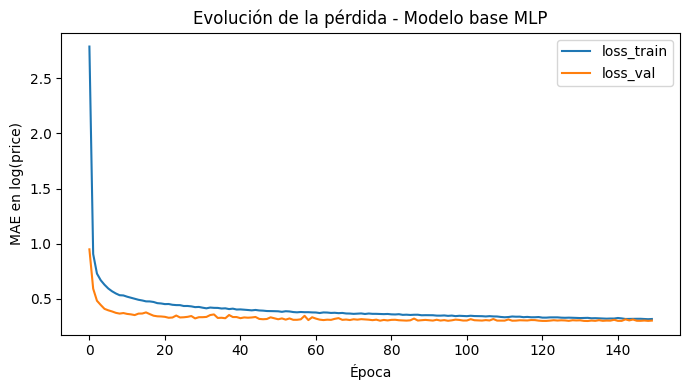

MAE en log(price) - test: 0.2925
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE aproximado en price (escala original): 164.79


In [4]:
import matplotlib.pyplot as plt

# Entreno un primer modelo base con la arquitectura por defecto
# para tener una referencia de desempeño y revisar que el entrenamiento sea estable.

baseline_model = build_mlp_model(
    n_hidden_layers=2,
    units_per_layer=64,
    dropout_rate=0.10,
    learning_rate=0.001
)

# EarlyStopping para no quedarme entrenando de más una arquitectura que ya dejó de mejorar
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Entrenamiento del modelo base
history_base = baseline_model.fit(
    X_train_nn,
    y_train_nn,
    epochs=150,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Convierto el historial a DataFrame para poder graficar más fácil
hist_base = pd.DataFrame(history_base.history)
hist_base["epoch"] = history_base.epoch

print(hist_base.tail())

# Curva de pérdida (MAE) en entrenamiento y validación
plt.figure(figsize=(7, 4))
plt.plot(hist_base["loss"], label="loss_train")
plt.plot(hist_base["val_loss"], label="loss_val")
plt.xlabel("Época")
plt.ylabel("MAE en log(price)")
plt.title("Evolución de la pérdida - Modelo base MLP")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluación en el conjunto de prueba en escala log(price)
test_loss_log, test_mae_log = baseline_model.evaluate(X_test_nn, y_test_nn, verbose=0)
print(f"MAE en log(price) - test: {test_mae_log:.4f}")

# Paso el error a escala de precio original para tener una idea más intuitiva (en dólares)
y_pred_test_log = baseline_model.predict(X_test_nn).flatten()
y_pred_test_price = np.exp(y_pred_test_log)
y_test_price = np.exp(y_test_nn)

mae_price = np.mean(np.abs(y_pred_test_price - y_test_price))
print(f"MAE aproximado en price (escala original): {mae_price:.2f}")


In [5]:
import matplotlib.pyplot as plt

# Lista donde voy a ir guardando todo lo que salga de cada modelo
hp_results = []

# Defino varias configuraciones de hiperparámetros
# Capas, unidades variadas, dropout y learning rate distintos
config_1  = {"n_layers": 1, "units": 32,  "dropout": 0.00, "lr": 0.001}
config_2  = {"n_layers": 1, "units": 64,  "dropout": 0.10, "lr": 0.001}
config_3  = {"n_layers": 1, "units": 96,  "dropout": 0.20, "lr": 0.0005}

config_4  = {"n_layers": 2, "units": 48,  "dropout": 0.10, "lr": 0.001}
config_5  = {"n_layers": 2, "units": 64,  "dropout": 0.20, "lr": 0.001}
config_6  = {"n_layers": 2, "units": 96,  "dropout": 0.10, "lr": 0.0005}

config_7  = {"n_layers": 3, "units": 64,  "dropout": 0.10, "lr": 0.001}
config_8  = {"n_layers": 3, "units": 96,  "dropout": 0.20, "lr": 0.001}
config_9  = {"n_layers": 3, "units": 128, "dropout": 0.20, "lr": 0.0005}

config_10 = {"n_layers": 4, "units": 64,  "dropout": 0.15, "lr": 0.001}
config_11 = {"n_layers": 4, "units": 96,  "dropout": 0.25, "lr": 0.001}
config_12 = {"n_layers": 4, "units": 128, "dropout": 0.15, "lr": 0.0005}

config_13 = {"n_layers": 5, "units": 64,  "dropout": 0.20, "lr": 0.001}
config_14 = {"n_layers": 5, "units": 96,  "dropout": 0.30, "lr": 0.001}
config_15 = {"n_layers": 5, "units": 128, "dropout": 0.25, "lr": 0.0005}
config_16 = {"n_layers": 3, "units": 160, "dropout": 0.20, "lr": 0.0005}

config_list = [
    config_1, config_2, config_3,
    config_4, config_5, config_6,
    config_7, config_8, config_9,
    config_10, config_11, config_12,
    config_13, config_14, config_15,
    config_16
]

print("Número de configuraciones que voy a probar:", len(config_list))

for i, cfg in enumerate(config_list, start=1):
    print("\n====================================")
    print(f"Modelo {i}")
    print(f"Capas: {cfg['n_layers']}, unidades: {cfg['units']}, dropout: {cfg['dropout']}, lr: {cfg['lr']}")
    
    # Construyo el modelo con esta configuración
    model_tmp = build_mlp_model(
        n_hidden_layers=cfg["n_layers"],
        units_per_layer=cfg["units"],
        dropout_rate=cfg["dropout"],
        learning_rate=cfg["lr"]
    )
    
    # Early stopping para evitar sobreentrenar modelos que dejan de mejorar
    early_stop_tmp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    history_tmp = model_tmp.fit(
        X_train_nn,
        y_train_nn,
        epochs=120,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early_stop_tmp],
        verbose=0
    )
    
    # Mejor MAE de validación (en log(price)) que alcanzó este modelo
    best_val_mae_log = float(np.min(history_tmp.history["val_loss"]))
    
    # Evaluación en el conjunto de prueba en log(price)
    test_loss_log, test_mae_log = model_tmp.evaluate(X_test_nn, y_test_nn, verbose=0)
    
    # Paso a escala original para tener una idea del error en dólares
    y_pred_test_log_tmp = model_tmp.predict(X_test_nn, verbose=0).flatten()
    y_pred_test_price_tmp = np.exp(y_pred_test_log_tmp)
    y_test_price_tmp = np.exp(y_test_nn)
    mae_price_tmp = float(np.mean(np.abs(y_pred_test_price_tmp - y_test_price_tmp)))
    
    # Número de épocas reales entrenadas
    epochs_trained = len(history_tmp.history["loss"])
    
    # Guardo resultados de este modelo
    hp_results.append({
        "model_id": i,
        "n_layers": cfg["n_layers"],
        "units": cfg["units"],
        "dropout": cfg["dropout"],
        "learning_rate": cfg["lr"],
        "best_val_mae_log": best_val_mae_log,
        "test_mae_log": float(test_mae_log),
        "mae_price": mae_price_tmp,
        "epochs_trained": epochs_trained,
        "history": history_tmp,
        "model_obj": model_tmp
    })
    
    print(f"Mejor val MAE (log): {best_val_mae_log:.4f}")
    print(f"MAE test (log): {test_mae_log:.4f}")
    print(f"MAE aproximado en price: {mae_price_tmp:.2f}")


Número de configuraciones que voy a probar: 16

Modelo 1
Capas: 1, unidades: 32, dropout: 0.0, lr: 0.001
Mejor val MAE (log): 0.3567
MAE test (log): 0.3263
MAE aproximado en price: 433.44

Modelo 2
Capas: 1, unidades: 64, dropout: 0.1, lr: 0.001
Mejor val MAE (log): 0.3371
MAE test (log): 0.3099
MAE aproximado en price: 179.35

Modelo 3
Capas: 1, unidades: 96, dropout: 0.2, lr: 0.0005
Mejor val MAE (log): 0.3270
MAE test (log): 0.3090
MAE aproximado en price: 200.08

Modelo 4
Capas: 2, unidades: 48, dropout: 0.1, lr: 0.001
Mejor val MAE (log): 0.3202
MAE test (log): 0.3082
MAE aproximado en price: 183.65

Modelo 5
Capas: 2, unidades: 64, dropout: 0.2, lr: 0.001
Mejor val MAE (log): 0.3189
MAE test (log): 0.3063
MAE aproximado en price: 175.24

Modelo 6
Capas: 2, unidades: 96, dropout: 0.1, lr: 0.0005
Mejor val MAE (log): 0.3123
MAE test (log): 0.3039
MAE aproximado en price: 169.68

Modelo 7
Capas: 3, unidades: 64, dropout: 0.1, lr: 0.001
Mejor val MAE (log): 0.3234
MAE test (log): 0.3